# 2D Gaussian clusters

## Exercise 1.1

To load the dataset, the `numpy.loadtxt` method can be used. This time, the dataset file contains an header in the first line. We will skip it using the method iself.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
X_gauss = np.loadtxt("data/2D_gauss_clusters.txt", delimiter=",", skiprows=1)
X_gauss

array([[845753., 636607.],
       [812954., 643720.],
       [868217., 609046.],
       ...,
       [706472., 171207.],
       [659128., 142611.],
       [665898.,  98088.]])

## Exercise 1.2

Let's use now `matplotlib` to explore our 2D data. Since we are likely going to need a scatter plot multiple times, we can define a simple function to handle it.
> **Hint:** You may use the function `plt.scatter`

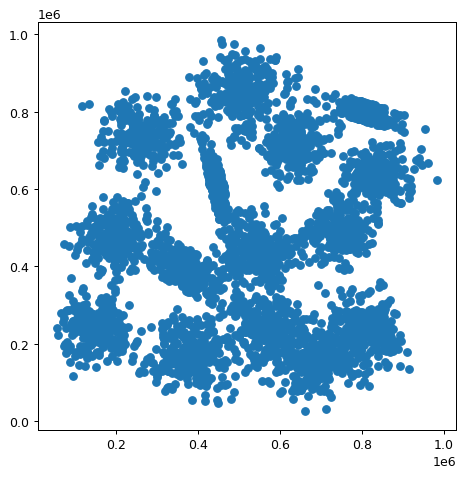

In [4]:
def plot_2d_scatter(X):
    """Display a 2D scatter plot

    :param X: input data points, array
    :return: fig, ax, objects
    """
    fig, ax = plt.subplots(figsize=(6, 6), dpi=90)
    ax.scatter(X[:,0], X[:,1])
    return fig, ax # use them for further modifications

_, _ = plot_2d_scatter(X_gauss) # the two underscores let you discard the returned values

Gaussian, globular clusters are easily visible in the euclidean space. At first sight, you can count up to 15 clusters. Most of them have a regular shape, while some others are more elongated. Given this distribution, we known from theory that the K-means algorithm can achieve positive clustering performance (provided that the right number of cluster is chosen).

## Exercises 1.3

Let's implement now our version of the K-means algorithm. We will use a custom Python class. The basic blocks will be:

- a `fit_predict` method exposed to the users of the class
- a stateful structure: we do want to save the final clusters labels and centroids
- some internal plotting functions
- a `dump_to_file` method to save cluster labels to CSV file (see Exercise 1.4)

In [5]:
class KMeans:
    def __init__(self, n_clusters, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels = None
    
    def __init_random_centroids(self, X):
        c_idx = np.random.randint(0, X.shape[0], self.n_clusters)
        c = X[c_idx] # fancy-indexing
        return c

    def fit_predict(self, X):
        """Run the K-means clustering on X.
        
        :param X: input data points, array, shape = (N,C).
        :return: labels : array, shape = N.
        """
        # For each point, store the positional index of the closest centroid
        nearest = np.empty(X.shape[0])
        
        c_out = self.__init_random_centroids(X)
        for j in range(self.max_iter):
            nearest_prev = nearest

            # For each point in X, compute the squared distance from each centroid
            # dist will have shape: (n_clusters, X.shape[0])
            dist = np.array([np.sum((X-c_out[i])**2, axis=1) for i in range(self.n_clusters)])

            # Find the nearest centroid for each point using argmin
            # nearest will have shape: (X.shape[0],)
            nearest = dist.argmin(axis=0)

            # Early stopping if centroids have not changed 
            if np.array_equal(nearest, nearest_prev):
                print(f"Early stopping at iteration {j}!")
                break

            # For each cluster, compute the average coordinates considering only points currently
            # assigned to it. Then, use them as the new centroid coordinates.
            for i in range(self.n_clusters):
                c_temp = X[nearest == i].mean(axis=0) # indexing with a mask 
                if not np.isnan(c_temp).any(): # handle the case of an empty cluster
                    c_out[i] = c_temp
            
        self.centroids = c_out
        self.labels = nearest
        return self.labels
    
    def dump_to_file(self, filename):
        """Dump the evaluated labels to a CSV file."""
        with open(filename, 'w') as fp:
            fp.write('Id,ClusterId\n')
            for i, label in enumerate(self.labels):
                fp.write(f'{i},{label:d}\n')

In [6]:
np.random.seed(0)
kmeans_model = KMeans(10)
l_gauss = kmeans_model.fit_predict(X_gauss)
l_gauss

Early stopping at iteration 11!


array([1, 1, 1, ..., 5, 5, 5])

In [7]:
kmeans_model.dump_to_file('gauss_labels.csv')